# Dataset overview
Gather basic values to characterize dataset

In [1]:
!which python

/sw/spack-rhel6/miniforge3-4.9.2-3-Linux-x86_64-pwdbqi/bin/python


In [2]:
pwd

'/mnt/lustre02/work/mh0010/m300408/EUREC4A_CloudClassification/manual/EUREC4A_manualclassifications/notebooks'

In [3]:
import glob
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
level1_dataset = '../processed_data/EUREC4A_ManualClassifications_l1.nc'

In [5]:
color_dict = {'Flowers':'#2281BB', 'Fish': '#93D2E2', 'Gravel': '#3EAE47','Sugar': '#A1D791'}

In [6]:
ds_l1 = xr.open_dataset(level1_dataset)

In [7]:
ds_l1

<xarray.Dataset>
Dimensions:            (index: 15303)
Coordinates:
  * index              (index) int32 0 1 2 3 4 ... 15298 15299 15300 15301 15302
Data variables: (12/23)
    classification_id  (index) int32 ...
    user_name          (index) object ...
    user_id            (index) float64 ...
    workflow_id        (index) int16 ...
    workflow_name      (index) object ...
    created_at         (index) datetime64[ns] ...
    ...                 ...
    init_date          (index) datetime64[ns] ...
    instrument         (index) object ...
    lon0               (index) float64 ...
    lat0               (index) float64 ...
    lon1               (index) float64 ...
    lat1               (index) float64 ...
Attributes:
    title:           EUREC4A: manual meso-scale cloud pattern classifications
    description:     Level-1: restructured enhanced raw data
    author:          Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_on:      2021-11-23 09:48 UTC
    created_with:    create_level1.py with its last modification on Mon Nov 2...
    version:         --
    python_version:  3.8.6 | packaged by conda-forge | (default, Nov 27 2020,...
    doi:             not yet set

In [8]:
# Remove none labels
labels = [str(l.values).replace('Flower', 'Flowers') for l in ds_l1.tool_label]
instrument = [str(l.values) for l in ds_l1.instrument]
workflow = [str(l.values) for l in ds_l1.workflow_name]
ds_l1.tool_label.values = labels
ds_l1.instrument.values = instrument
ds_l1.workflow_name.values = workflow

In [9]:
label_mask = ~(ds_l1.tool_label.values == '')

In [10]:
print('Empty labels:', len(ds_l1.tool_label.values) - np.sum(label_mask))

Empty labels: 2731


In [11]:
ds_l1_woempty = ds_l1.isel(index=label_mask)

In [12]:
basic_numbers_dict = {}

# Totals:
basic_numbers_dict['global'] = {}
basic_numbers_dict['global']['Classifications'] = len(np.unique(ds_l1_woempty.classification_id))
basic_numbers_dict['global']['Labels'] = len(ds_l1_woempty.tool_label)
basic_numbers_dict['global']['Users'] = len(np.unique(ds_l1_woempty.user_name))

for workflow, grp in ds_l1_woempty.groupby(ds_l1_woempty.workflow_name):
    for instrument, grp_inst in grp.groupby(grp.instrument):
        print(workflow, len(np.unique(grp_inst.subject_ids)), len(np.unique(grp_inst.user_name)))
        basic_numbers_dict['_'.join([workflow,instrument])] = {'subject_nb':len(np.unique(grp_inst.subject_ids)),
                                        'user_nb': len(np.unique(grp_inst.user_name)),
                                        'classification_nb': len(np.unique(grp_inst.classification_id)),
                                        'label_nb': len(grp_inst.classification_id),
                                        'instrument': instrument
                                       }
        for label, grp_label in grp_inst.groupby(grp_inst.tool_label):
            print(label, len(grp_label.classification_id))
            basic_numbers_dict['_'.join([workflow,instrument])][label] = len(grp_label.classification_id)

EUREC4A (ICON; albedo) 369 22
Fish 444
Flowers 287
Gravel 423
Sugar 65
EUREC4A (IR) 548 27
Fish 658
Flowers 917
Gravel 1138
Sugar 1480
EUREC4A (VIS) 234 40
Fish 992
Flowers 818
Gravel 1758
Sugar 1413
EUREC4A (VIS) 94 39
Fish 405
Flowers 452
Gravel 613
Sugar 709


In [13]:
basic_numbers_dict

{'global': {'Classifications': 7027, 'Labels': 12572, 'Users': 50},
 'EUREC4A (ICON; albedo)_n/a': {'subject_nb': 369,
  'user_nb': 22,
  'classification_nb': 674,
  'label_nb': 1219,
  'instrument': 'n/a',
  'Fish': 444,
  'Flowers': 287,
  'Gravel': 423,
  'Sugar': 65},
 'EUREC4A (IR)_ABI': {'subject_nb': 548,
  'user_nb': 27,
  'classification_nb': 2525,
  'label_nb': 4193,
  'instrument': 'ABI',
  'Fish': 658,
  'Flowers': 917,
  'Gravel': 1138,
  'Sugar': 1480},
 'EUREC4A (VIS)_ABI': {'subject_nb': 234,
  'user_nb': 40,
  'classification_nb': 2720,
  'label_nb': 4981,
  'instrument': 'ABI',
  'Fish': 992,
  'Flowers': 818,
  'Gravel': 1758,
  'Sugar': 1413},
 'EUREC4A (VIS)_MODIS': {'subject_nb': 94,
  'user_nb': 39,
  'classification_nb': 1108,
  'label_nb': 2179,
  'instrument': 'MODIS',
  'Fish': 405,
  'Flowers': 452,
  'Gravel': 613,
  'Sugar': 709}}

In [14]:
labels = [str(l.values) for l in grp.tool_label]

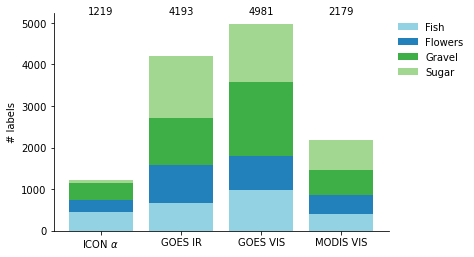

In [15]:
v = np.zeros((4))
v_ = np.zeros((4))
workflows = []
workflows = [r'ICON $\alpha$', 'GOES IR', 'GOES VIS', 'MODIS VIS']
for label in ['Fish', 'Flowers', 'Gravel', 'Sugar']:
    w = 0
    for workflow, workflow_dict in basic_numbers_dict.items():
        if workflow == 'global': continue
        if 'liquid' in workflow: continue
        total_label_nb = workflow_dict['label_nb']
        v_[w] = workflow_dict[label]#/total_label_nb*100
        w+=1
        if label == 'Fish':
#             workflows.append(workflow)
            plt.text(w-1,5200, total_label_nb, horizontalalignment='center')
    
    plt.bar(workflows, v_, bottom=v, orientation='vertical', color=color_dict[label], label=label)
    v += v_
plt.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')
# plt.ylabel('% labels');
plt.ylabel('# labels');
sns.despine()
# plt.savefig('../figures/overview_labels.pdf',bbox_inches='tight')

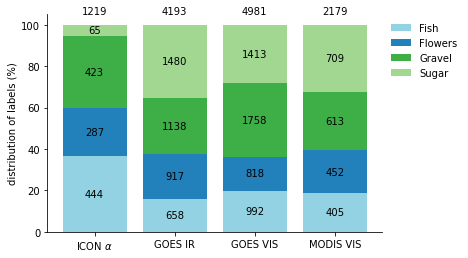

In [16]:
v = np.zeros((4))
v_ = np.zeros((4))
workflows = []
workflows = [r'ICON $\alpha$', 'GOES IR', 'GOES VIS', 'MODIS VIS']
for label in ['Fish', 'Flowers', 'Gravel', 'Sugar']:
    w = 0
    for workflow, workflow_dict in basic_numbers_dict.items():
        if workflow == 'global': continue
        if 'liquid' in workflow: continue
        total_label_nb = workflow_dict['label_nb']
        v_[w] = workflow_dict[label]/total_label_nb*100
        w+=1
        if label == 'Fish':
#             workflows.append(workflow)
            plt.text(w-1,105, total_label_nb, horizontalalignment='center')
        plt.text(w-1,v[w-1]+v_[w-1]/2,
                 workflow_dict[label],
                 verticalalignment='center',
                 horizontalalignment='center',color='black')
    
    plt.bar(workflows, v_, bottom=v, orientation='vertical', color=color_dict[label], label=label)
    v += v_
plt.legend(frameon=False, bbox_to_anchor=(1,1), loc='upper left')
# plt.ylabel('% labels');
plt.ylabel('distribution of labels (%)');
sns.despine()
# plt.savefig('../figures/overview_labels_relative.pdf',bbox_inches='tight')

In [17]:
basic_numbers_dict = {}

# Totals:
basic_numbers_dict['global'] = {}
basic_numbers_dict['global']['Classifications'] = len(np.unique(ds_l1.classification_id))
basic_numbers_dict['global']['Labels'] = len(ds_l1.tool_label)
basic_numbers_dict['global']['Users'] = len(np.unique(ds_l1.user_name))

for workflow, grp in ds_l1.groupby(ds_l1.workflow_name):
    for instrument, grp_inst in grp.groupby(grp.instrument):
        views = []
        for sbj, g in grp.groupby('subject_ids'):
            views.append(len(np.unique(g.classification_id)))
        print('{} ({}): viewing average: {} participants'.format(workflow, instrument, np.round(np.mean(views),1)))

EUREC4A (ICON; albedo) (n/a): viewing average: 2.8 participants
EUREC4A (IR) (ABI): viewing average: 6.4 participants
EUREC4A (VIS) (ABI): viewing average: 15.2 participants
EUREC4A (VIS) (MODIS): viewing average: 15.2 participants
